In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
# avoid font type 3, use TrueType font http://phyletica.org/matplotlib-fonts/
plt.rcParams['mathtext.fontset']= 'cm'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

## Load config file:
Because the config file located in a different foder, first we add the parent path into this working space.

In [2]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, "..")
cfg = importlib.import_module('config.turtlebot3_config_pytorch').config
print(cfg)

{'robot': 'turtlebot3', 'scenario': 'triangle', 'look_back': 120, 'look_ahead': 1, 'step_train': 1, 'step_test': 1, 'feature_in': ['pose_pose_position_x', 'pose_pose_position_y', 'pose_pose_orientation_z', 'pose_pose_orientation_w', 'twist_twist_linear_x', 'twist_twist_angular_z'], 'feature_out': ['pose_pose_position_x', 'pose_pose_position_y', 'pose_pose_orientation_z', 'pose_pose_orientation_w'], 'inversed': False, 'synthesized_test': True, 'synthesized_prob': 0.005, 'synthesized_type': 'burst', 'synthesized_burst_width': 10, 'hidden_size': 300, 'num_layers': 1, 'droprate': 0.1, 'bidirection': True, 'batch_size': 512, 'loss': 'mean_squared_error', 'optimizer': 'Adam', 'learning_rate': 0.0005, 'teacher_forcing_ratio': 0.95, 'use_gpu': True, 'validation': True, 'batch_size_inference': 1024}


In [31]:
cfg={
'feature_in': ['pose_pose_position_x', 
               'pose_pose_position_y', 
               'pose_pose_orientation_z', 
               'pose_pose_orientation_w', 
               'twist_twist_linear_x',
               'twist_twist_linear_y',
               'twist_twist_linear_z',
               'twist_twist_angular_x',
               'twist_twist_angular_y',
               'twist_twist_angular_z',
              ], 
'feature_out': ['pose_pose_position_x',
                'pose_pose_position_y', 
                'pose_pose_orientation_z', 
                'pose_pose_orientation_w',
               'twist_twist_linear_x',
               'twist_twist_linear_y',
               'twist_twist_linear_z',
               'twist_twist_angular_x',
               'twist_twist_angular_y',
               'twist_twist_angular_z',]
}

# Part 1: Load data and plot data

The dataset is collected in the simulated environment (`turtlebot3_myworld.launch`) in Gazebo environment with three files: 
* cmd_vel.csv: consists of control command sent from move_base controller.
* imd.csv: contains raw IMU data.
* odometry.csv: contains odometry of mobile robot.


In [4]:
data_dir = '../dataset/turtlebot3/normal_pentagon'
temp_odom = pd.read_csv('{}/odometry.csv'.format(data_dir))

In [5]:
temp_odom.head(60)

header_seq  h_stamp_secs  h_stamp_nsecs  pose_pose_position_x  \
0        10744           358      325000000             -1.821317   
1        10745           358      358000000             -1.823056   
2        10746           358      392000000             -1.824882   
3        10747           358      425000000             -1.826648   
4        10748           358      458000000             -1.828421   
5        10749           358      492000000             -1.830257   
6        10750           358      525000000             -1.832136   
7        10751           358      555000000             -1.834069   
8        10752           358      592000000             -1.836060   
9        10753           358      625000000             -1.837876   
10       10754           358      658000000             -1.839646   
11       10755           358      692000000             -1.841499   
12       10756           358      725000000             -1.843239   
13       10757           358      758000000             -1.844931   
14       10758           358      792000000             -1.846640   
15       10759           358      825000000             -1.848362   
16       10760           358      858000000             -1.850178   
17       10761           358      892000000             -1.852118   
18       10762           358      925000000             -1.853929   
19       10763           358      958000000             -1.855702   
20       10764           358      992000000             -1.857487   
21       10765           359       25000000             -1.859245   
22       10766           359       58000000             -1.861018   
23       10767           359       92000000             -1.862809   
24       10768           359      125000000             -1.864438   
25       10769           359      158000000             -1.866001   
26       10770           359      192000000             -1.867584   
27       10771           359      225000000             -1.869053   
28       10772           359      258000000             -1.870447   
29       10773           359      292000000             -1.871838   
30       10774           359      325000000             -1.873231   
31       10775           359      358000000             -1.874719   
32       10776           359      392000000             -1.876263   
33       10777           359      425000000             -1.877687   
34       10778           359      458000000             -1.879071   
35       10779           359      492000000             -1.880472   
36       10780           359      525000000             -1.881759   
37       10781           359      558000000             -1.883005   
38       10782           359      592000000             -1.884271   
39       10783           359      625000000             -1.885421   
40       10784           359      658000000             -1.886526   
41       10785           359      692000000             -1.887647   
42       10786           359      724000000             -1.888759   
43       10787           359      758000000             -1.889968   
44       10788           359      792000000             -1.891310   
45       10789           359      825000000             -1.892699   
46       10790           359      858000000             -1.894179   
47       10791           359      892000000             -1.895741   
48       10792           359      925000000             -1.897194   
49       10793           359      958000000             -1.898622   
50       10794           359      992000000             -1.900088   
51       10795           360       25000000             -1.901452   
52       10796           360       58000000             -1.902792   
53       10797           360       92000000             -1.904089   
54       10798           360      125000000             -1.905319   
55       10799           360      158000000             -1.906548   
56       10800           360      192000000             -1.907778   
57

Look at the above table, we can guess the collected frequency of odometry is 30 Hz.

In [6]:
temp_odom.describe()

header_seq  h_stamp_secs  h_stamp_nsecs  pose_pose_position_x  \
count  35660.000000  35660.000000   3.566000e+04          35660.000000   
mean   28573.500000    952.133259   5.083182e+08             -0.017236   
std    10294.299636    343.143376   2.885021e+08              1.428976   
min    10744.000000    358.000000   2.200000e+07             -2.057015   
25%    19658.750000    655.000000   2.580000e+08             -1.422689   
50%    28573.500000    952.000000   5.225000e+08             -0.021546   
75%    37488.250000   1249.000000   7.580000e+08              1.435577   
max    46403.000000   1546.000000   9.930000e+08              2.022790   

       pose_pose_position_y  pose_pose_position_z  pose_pose_orientation_x  \
count          35660.000000          3.566000e+04             35660.000000   
mean               0.103309         -1.001558e-03                 0.000242   
std                1.395437          3.368152e-07                 0.002652   
min               -1.960876         -1.002863e-03                -0.003862   
25%               -1.342462         -1.001766e-03                -0.002396   
50%                0.065225         -1.001567e-03                 0.000177   
75%                1.665548         -1.001419e-03                 0.002950   
max                1.966915         -1.000394e-03                 0.003862   

       pose_pose_orientation_y  pose_pose_orientation_z  \
count             35660.000000             35660.000000   
mean                  0.000242                -0.062659   
std                   0.002652                 0.688029   
min                  -0.003862                -0.999993   
25%                  -0.002396                -0.765122   
50%                   0.000177                -0.047268   
75%                   0.002950                 0.622624   
max                   0.003862                 0.999993   

       pose_pose_orientation_w  twist_twist_linear_x  twist_twist_linear_y  \
count             35660.000000          35660.000000          35660.000000   
mean                 -0.010361              0.162223              0.000036   
std                   0.722908              0.087552              0.000155   
min                  -0.999993             -0.231394             -0.003112   
25%                  -0.750956              0.113191             -0.000007   
50%                  -0.011448              0.207588              0.000019   
75%                   0.748009              0.220138              0.000065   
max                   0.999993              0.235744              0.006923   

       twist_twist_linear_z  twist_twist_angular_x  twist_twist_angular_y  \
count               35660.0                35660.0                35660.0   
mean                    0.0                    0.0                    0.0   
std                     0.0                    0.0                    0.0   
min                     0.0                    0.0                    0.0   
25%                     0.0                    0.0                    0.0   
50%                     0.0                    0.0                    0.0   
75%                     0.0                    0.0                    0.0   
max                     0.0                    0.0                    0.0   

       twist_twist_angular_z  
count           35660.000000  
mean               -0.075654  
std                 0.253524  
min                -1.634813  
25%                -0.171349  
50%                -0.050528  
75%                 0.020410  
max                 1.706848

## Plot input and output feature data

<AxesSubplot:>

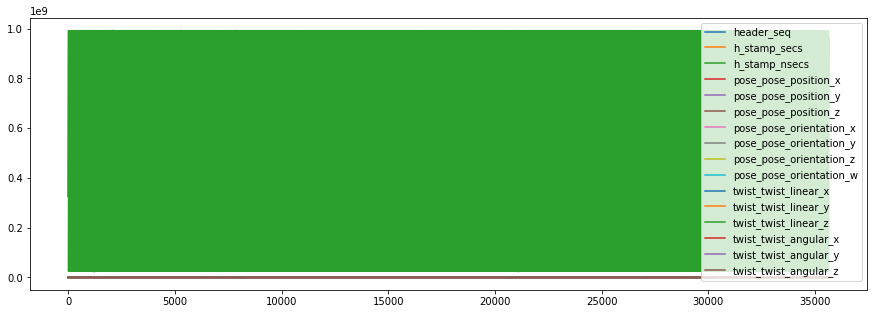

In [8]:
temp_odom.plot.line(figsize=(15,5))

<AxesSubplot:title={'center':'Feature input (Position)'}>

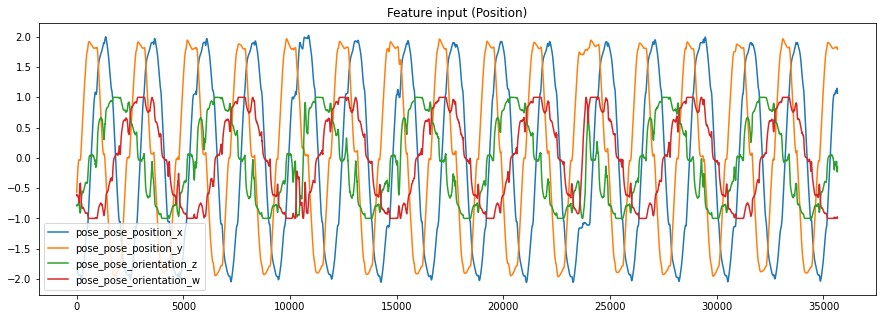

In [27]:
temp_odom.plot.line(y=cfg['feature_in'][:4], title='Feature input (Position)', figsize=(15,5))

<AxesSubplot:title={'center':'Feature input (Twist cmd_vel)'}>

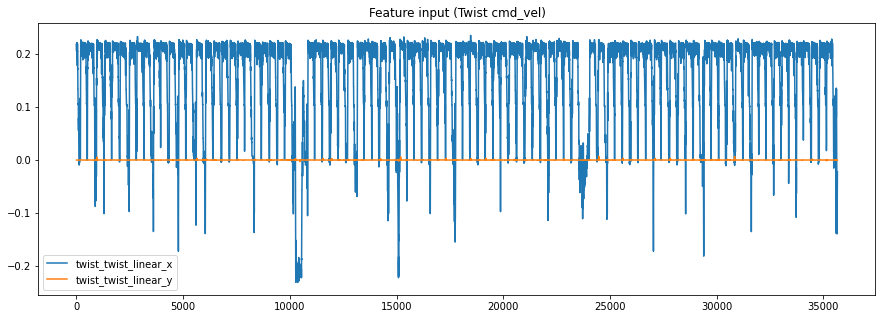

In [28]:
temp_odom.plot.line(y=cfg['feature_in'][4:6], title='Feature input (Twist cmd_vel)', figsize=(15,5))

<AxesSubplot:title={'center':'Feature input (Twist cmd_vel)'}>

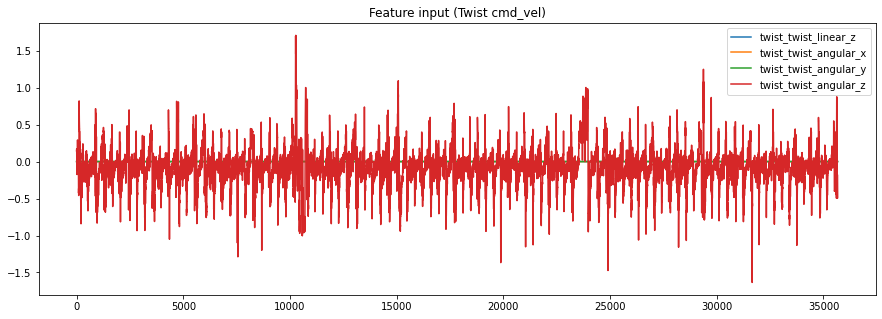

In [29]:
temp_odom.plot.line(y=cfg['feature_in'][6:10], title='Feature input (Twist cmd_vel)', figsize=(15,5))

<AxesSubplot:title={'center':'Feature out (Position output)'}>

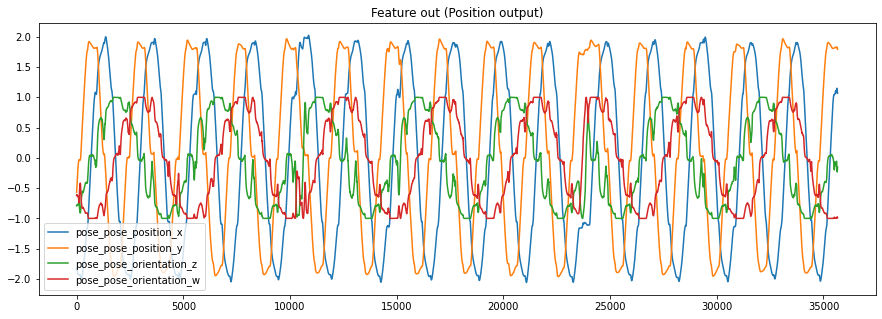

In [34]:
temp_odom.plot.line(y=cfg['feature_out'][0:4],
                    title='Feature out (Position output)', figsize=(15,5))

<AxesSubplot:title={'center':'Feature out (Position output)'}>

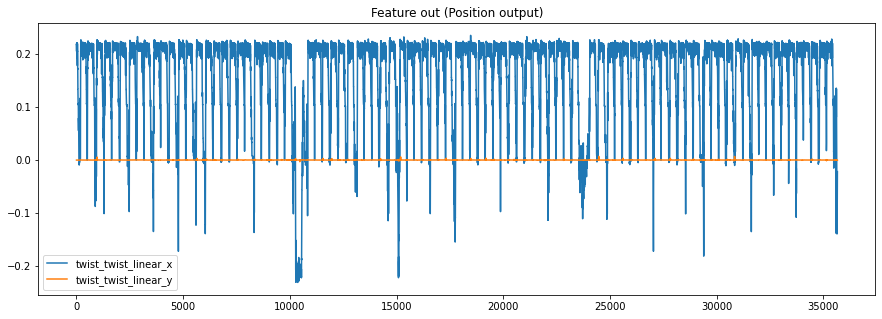

In [36]:
temp_odom.plot.line(y=cfg['feature_out'][4:6],
                    title='Feature out (Position output)', figsize=(15,5))

<AxesSubplot:title={'center':'Feature out (Position output)'}>

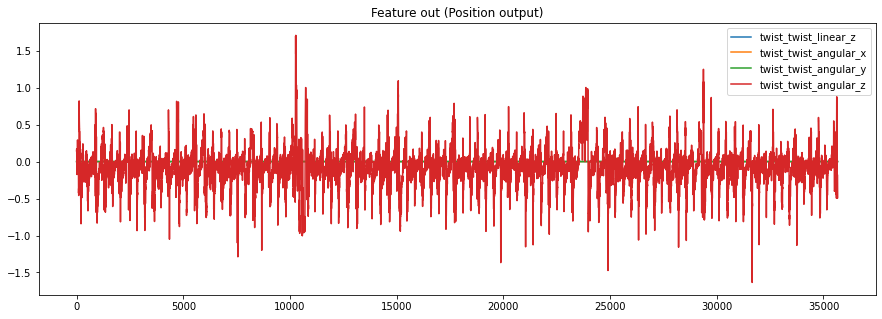

In [37]:
temp_odom.plot.line(y=cfg['feature_out'][6:10],
                    title='Feature out (Position output)', figsize=(15,5))

## Standardizing data 

In [24]:
from sklearn.preprocessing import StandardScaler
def standardize(data):
    scaler = StandardScaler()
    print("shape data={}".format(data.shape))
    print("data mean {}, data variance {}".format(np.mean(data, axis=0),np.var(data, axis=0)))
    data = scaler.fit_transform(data)
    print("shape transformed data={}".format(data.shape))
    print("Scaler Mean: {}".format(scaler.mean_))
    print("Scaler Variance: {}".format(scaler.var_))
    print("data mean {}, data variance {}".format(np.mean(data, axis=0),np.var(data, axis=0)))
    return data, scaler

In [76]:
in_dataset = temp_odom[cfg['feature_in']]
out_dataset = temp_odom[cfg['feature_out']]
print("in_dataset={}, out_dataset={}".format(in_dataset.shape, out_dataset.shape))
len_data =len(in_dataset)
origin_input_train_set = in_dataset[:int(0.7*len_data)]
origin_input_test_set = in_dataset[int(0.7*len_data):]
origin_output_train_set = out_dataset[:int(0.7*len_data)]
origin_output_test_set = out_dataset[int(0.7*len_data):]
print("origin_input_train_set={}".format(origin_input_train_set.shape))
print("origin_output_train_set={}".format(origin_output_train_set.shape))

in_dataset=(32510, 2), out_dataset=(32510, 2)
origin_input_train_set=(22757, 2)
origin_output_train_set=(22757, 2)


In [77]:
train_input_data, input_scaler = standardize(origin_input_train_set)
test_input_data = input_scaler.transform(origin_input_test_set)
train_output_data, output_scaler = standardize(origin_output_train_set)
test_output_data = output_scaler.transform(origin_output_test_set)
print("train_input_data={}".format(train_input_data.shape))
print("train_output_data={}".format(train_output_data.shape))

shape data=(22757, 2)
data mean pose_pose_position_x   -0.054903
pose_pose_position_y   -0.000911
dtype: float64, data variance pose_pose_position_x    1.990196
pose_pose_position_y    1.919198
dtype: float64
shape transformed data=(22757, 2)
Scaler Mean: [-0.05490261 -0.00091102]
Scaler Variance: [1.99019616 1.91919828]
data mean [ 2.49784325e-18 -1.24892163e-17], data variance [1. 1.]
shape data=(22757, 2)
data mean pose_pose_position_x   -0.054903
pose_pose_position_y   -0.000911
dtype: float64, data variance pose_pose_position_x    1.990196
pose_pose_position_y    1.919198
dtype: float64
shape transformed data=(22757, 2)
Scaler Mean: [-0.05490261 -0.00091102]
Scaler Variance: [1.99019616 1.91919828]
data mean [ 2.49784325e-18 -1.24892163e-17], data variance [1. 1.]
train_input_data=(22757, 2)
train_output_data=(22757, 2)


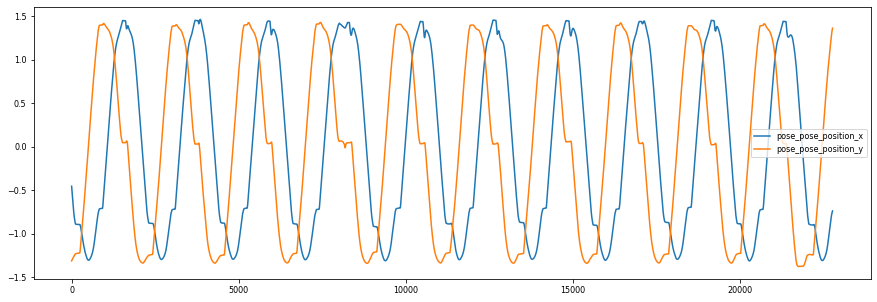

In [27]:
x = [i for i in range(len(train_input_data))]
plt.figure(figsize=(15,5))
for i,f in enumerate(cfg['feature_in']):
    plt.plot(x, train_input_data[:,i], label=f)
plt.legend()
plt.savefig("scaled_simu_turtlebot3_dataset.png",
                format='png', dpi=1000, bbox_inches="tight")
plt.show()

We split the messy figure into two figures, one with position while the other with twist cmd_vel.

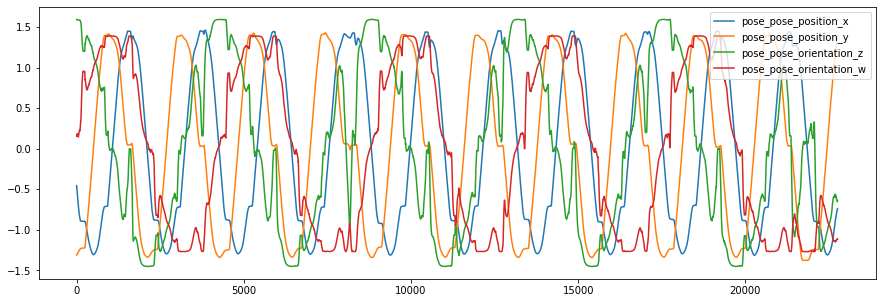

In [11]:
plt.figure(figsize=(15,5))
for i,f in enumerate(cfg['feature_in']):
    if 'pose_pose' in f:
        plt.plot(x, train_input_data[:,i], label=f)
plt.legend()
plt.savefig("scaled_simu_turtlebot3_position.png",
                format='png', dpi=1000, bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
for i,f in enumerate(cfg['feature_in']):
    if 'twist_twist' in f:
        plt.plot(x, train_input_data[:,i], label=f)
plt.legend()
plt.savefig("scaled_simu_turtlebot3_cmd_vel.png",
                format='png', dpi=1000, bbox_inches="tight")
plt.show()

In [ ]:
plot_len = 400
xx = [i for i in range(len(train_input_data[:plot_len]))]
plt.figure(figsize=(15,5))
for i,f in enumerate(cfg['feature_in']):
    if 'pose_pose' in f:
        plt.plot(xx, train_input_data[:plot_len,i], label=f)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
for i,f in enumerate(cfg['feature_in']):
    if 'twist_twist' in f:
        plt.plot(xx, train_input_data[:plot_len,i], label=f)
plt.legend()
plt.show()

## Part 1.3 Plot and verify the script of preprocessing data 
In this part, we import the functions of the pre-processing script and plot some seq input and sequence target

In [12]:
data = importlib.import_module('dataset.turtlebot3')

In [38]:
train_input, train_target = data.prepare_seq2seq_data(train_input_data,
        train_output_data, cfg['look_back'], cfg['look_ahead'], 
        cfg['step_window'])

In [39]:
print("train_input.shape={}, train_target.shape={}".format(
    train_input.shape, train_target.shape))
print("train_input[50,:30,1]={},\ntrain_target[50,:30,1]={}".format(
    train_input[50,:30,1], train_target[50,:30,1]))

train_input.shape=(1509, 120, 6), train_target.shape=(1509, 120, 4)
train_input[50,:30,1]=[1.18067996 1.18455984 1.18833606 1.19207712 1.19580308 1.19936133
 1.20280119 1.20625114 1.20956809 1.21303792 1.21689423 1.22085293
 1.22480368 1.22883718 1.23274485 1.23645957 1.24020597 1.24383382
 1.24754781 1.25145863 1.25529296 1.25917221 1.26314735 1.26693731
 1.27073875 1.27447077 1.27801201 1.28156059 1.2850049  1.28828947],
train_target[50,:30,1]=[1.23645957 1.24020597 1.24383382 1.24754781 1.25145863 1.25529296
 1.25917221 1.26314735 1.26693731 1.27073875 1.27447077 1.27801201
 1.28156059 1.2850049  1.28828947 1.29149958 1.29480582 1.29801927
 1.30127306 1.30447542 1.30743337 1.31019945 1.31292729 1.3155789
 1.31813907 1.320718   1.32320851 1.32566536 1.328197   1.33065674]


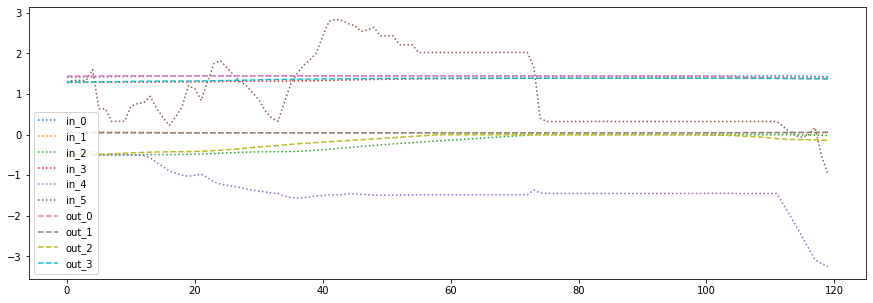

In [40]:
plt.figure(figsize=(15,5))
id = 100
plot_seqs = [train_input[id], train_target[id]]

xx = [i for i in range(cfg['look_back'])]

for i in range(len(cfg['feature_in'])):
    plt.plot(xx, train_input[id,:,i], label='in_{}'.format(i),linestyle=':')
    
for i in range(len(cfg['feature_out'])):
    plt.plot(xx, train_target[id,:,i], label='out_{}'.format(i),linestyle='--')
    
plt.legend()
plt.show()

## Part 1.2 Generate Synthesized Testset
We generate a synthesized testset which consists of some times of anomalies 
such as burst events, or peark signals adding to the normal data.

Adopt a method from Luo Tie paper: "Distributed Anomaly Detection using
Autoencoder Neural Networks in WSN for IoT". 

* **Spike**: a sharp rise followed immediately by a sharp decline in the sensor reading. Formally,
$$x'(t) = x(t) + vδ(t); $$
where $δ(t)$ is the Dirac delta function and $v$ is the magnitude of the spike.

* **Burst**: a continuous and constant offset persisting for a finite period of time. Formally,
$$x'(t) = \begin{cases}
     x(t) + v , t_\text{start} ≤ t ≤ t_\text{end}\\
        x(t), \text{otherwise}. 
     \end{cases}
$$

In both cases, $v$ can be negative.

For us, we get $v$ in between the range of sensor values for each dimension. 
We inject anomaly time $t$ at a random manner with probability p=15% of the normal dataset.

In [52]:
def generate_anomalous_spike_indices(length, prob):
    anomalous_labels = np.zeros(length)
    anomalous_indices = []
    i=0
    while i < length:                   
        if random.random() < prob:                 
            anomalous_labels[i] = 1.
            anomalous_indices.append(i)
        i+=1
    return np.array(anomalous_indices), anomalous_labels

In [94]:
def generate_anomalous_burst_indices(length, prob, burst_width):
    anomalous_labels = np.zeros(length)
    anomalous_indices = []
    i=0
    while i < length:                   
        if random.random() < prob:  
            for j in range(i, i+burst_width):
                if j >= length:
                    break
                else:                                                                  
                    anomalous_indices.append(j)
                    anomalous_labels[j] = 1.
            i += burst_width
        else:
            i += 1             
            
    return np.array(anomalous_indices), anomalous_labels

### Part 1.2.b: Generate and save the synthesized anomalous dataset as a test set
We name this test set with anomalous burst as: `test_input_anomaly_burst.npy` with probability of anomalous is 2% and each burst length is 50 samples which is half of our `look_back`. The groundtruth label is saved as `test_anomaly_burst_label.npy`

In [45]:
print(origin_input_test_set, len(cfg['feature_in']))

       pose_pose_position_x  pose_pose_position_y
22757             -1.095151              1.890439
22758             -1.093168              1.893364
22759             -1.091122              1.896361
22760             -1.089198              1.899156
22761             -1.087247              1.901958
...                     ...                   ...
32505              1.938364             -0.469622
32506              1.935965             -0.476257
32507              1.933519             -0.482971
32508              1.931022             -0.489797
32509              1.928508             -0.496615

[9753 rows x 2 columns] 2


In [63]:
#contaminate_rate
prob = 0.005
anomalous_indices, anomalous_labels = generate_anomalous_spike_indices(len(origin_input_test_set), prob)
print("anomalous_indices={}, anomalous_labels={}".format(anomalous_indices, anomalous_labels.shape))

anomalous_indices=[ 260  316  818  833 1025 1126 1220 1340 1388 1612 1860 1883 1933 2289
 2340 2358 3180 3230 3298 3451 3727 3760 4109 4187 4358 4753 5000 5177
 5243 5301 5385 5562 6292 6447 6477 6733 6829 7466 7728 7831 8018 8061
 9080 9150 9231 9347 9361 9435], anomalous_labels=(9753,)


In [78]:
synth_input_test = origin_input_test_set.copy()
synth_input_test.head()

pose_pose_position_x  pose_pose_position_y
22757             -1.095151              1.890439
22758             -1.093168              1.893364
22759             -1.091122              1.896361
22760             -1.089198              1.899156
22761             -1.087247              1.901958

In [79]:
synth_input_test.iloc[anomalous_indices]

pose_pose_position_x  pose_pose_position_y
23017              0.024199              1.875653
23073              0.423410              1.821558
23575              1.929775              0.062656
23590              1.969756              0.010310
23782              1.565578             -1.274119
23883              0.975166             -1.675547
23977              0.310626             -1.815674
24097             -0.559016             -1.828107
24145             -0.891493             -1.771488
24369             -1.361239             -1.492652
24617             -1.876999              0.185695
24640             -1.865389              0.351980
24690             -1.811523              0.706543
25046             -0.807464              1.965139
25097             -0.440171              1.925135
25115             -0.311860              1.910530
25937              1.659043             -0.024752
25987              1.764251             -0.323031
26055              1.728814             -0.812350
26208              1.086039             -1.653798
26484             -0.861879             -1.801705
26517             -1.072971             -1.783279
26866             -1.790166             -0.590848
26944             -1.900707             -0.035990
27115             -1.652854              1.157340
27510              0.010435              1.848694
27757              1.575879              1.156516
27934              1.949227              0.078004
28000              1.997697              0.026774
28058              1.954990              0.038393
28142              1.977922             -0.381454
28319              1.355923             -1.461659
29049             -1.847926             -0.388218
29204             -1.811184              0.733685
29234             -1.752047              0.940126
29490             -1.051678              1.938039
29586             -0.753055              1.966236
30223              1.943799              0.056862
30485              1.506435             -1.327599
30588              0.874684             -1.709986
30775             -0.468964             -1.848011
30818             -0.774799             -1.806045
31837             -0.131428              1.881661
31907              0.373550              1.821837
31988              0.942650              1.680525
32104              1.580433              1.169645
32118              1.627129              1.077555
32192              1.760238              0.555721

In [80]:
origin_input_test_set['pose_pose_position_x'].max()

2.02513106881

In [81]:
for col in cfg['feature_in']:
    max_x = origin_input_test_set[col].max()
    min_x = origin_input_test_set[col].min()
    spike_magnitude = random.uniform(min_x, max_x)
    for i in anomalous_indices:
        synth_input_test.iloc[i][col] += (-1)**i*spike_magnitude

<AxesSubplot:title={'center':'Origin input test set'}>

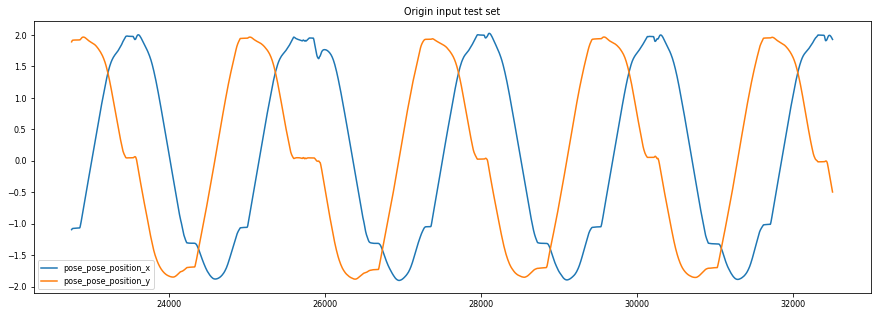

In [82]:
origin_input_test_set.plot.line(y=cfg['feature_in'], title='Origin input test set', figsize=(15,5))

<AxesSubplot:title={'center':'Synthesized input test set'}>

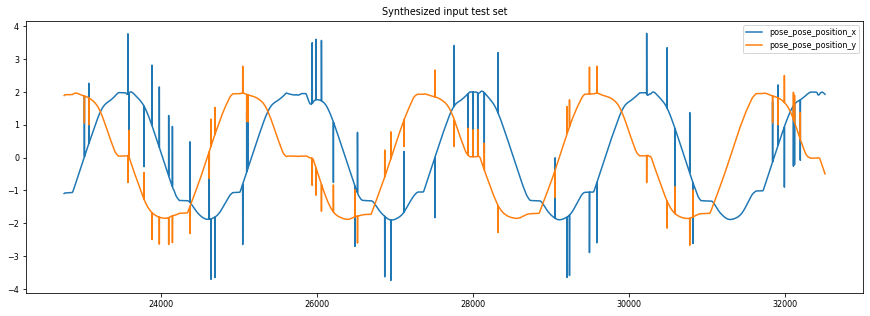

In [83]:
synth_input_test.plot.line(y=cfg['feature_in'], title='Synthesized input test set', figsize=(15,5))

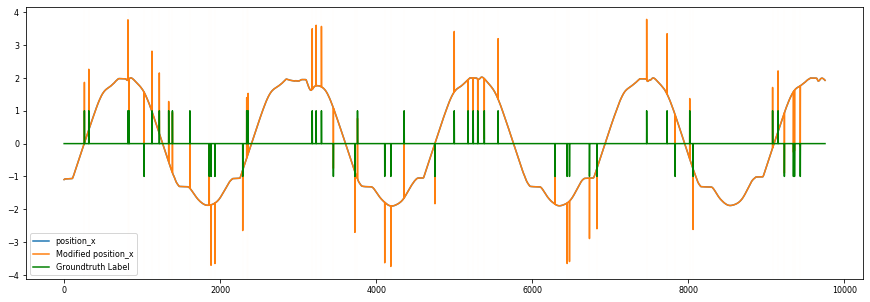

In [90]:
x = [i for i in range(len(origin_input_test_set))]
plt.figure(figsize=(15,5))
plt.plot(x, origin_input_test_set.values[:,0], label='position_x')
plt.plot(x, synth_input_test.values[:,0], label='Modified position_x')
for column in anomalous_indices:
    plt.axvline(x=column, color=sns.xkcd_rgb["peach"],alpha=.01)
plt.plot(x, anomalous_labels*np.sign(synth_input_test.values[:,0]), color='g', label='Groundtruth Label')
plt.legend()
plt.show()

#### Part 1.2.b.2 Burst anomaly generation

In [112]:
synth_burst_input_test = origin_input_test_set.copy()
synth_burst_input_test.head()

pose_pose_position_x  pose_pose_position_y
22757             -1.095151              1.890439
22758             -1.093168              1.893364
22759             -1.091122              1.896361
22760             -1.089198              1.899156
22761             -1.087247              1.901958

In [113]:
generate_anomalous_burst_indices
#contaminate_rate
prob = 0.005
burst_width = 20
anomalous_indices_burst, anomalous_labels_burst = generate_anomalous_burst_indices(len(origin_input_test_set),
                                                                                   prob, burst_width)
print("anomalous_indices={}, anomalous_labels={}".format(anomalous_indices_burst.shape, 
                                                         anomalous_labels_burst.shape))

anomalous_indices=(920,), anomalous_labels=(9753,)


In [114]:
for col in cfg['feature_in']:
    max_x = origin_input_test_set[col].max()
    min_x = origin_input_test_set[col].min()
    spike_magnitude = random.uniform(min_x, max_x)
    for i in anomalous_indices_burst:
        synth_burst_input_test.iloc[i][col] += (-1)**i*spike_magnitude

<AxesSubplot:title={'center':'Synthesized Burst input test set'}>

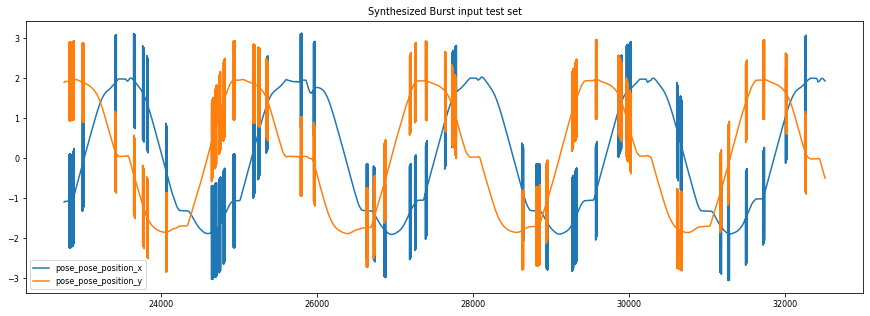

In [115]:
synth_burst_input_test.plot.line(y=cfg['feature_in'], title='Synthesized Burst input test set', figsize=(15,5))

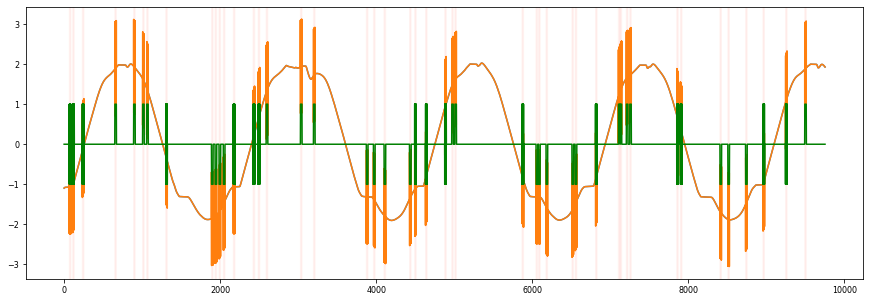

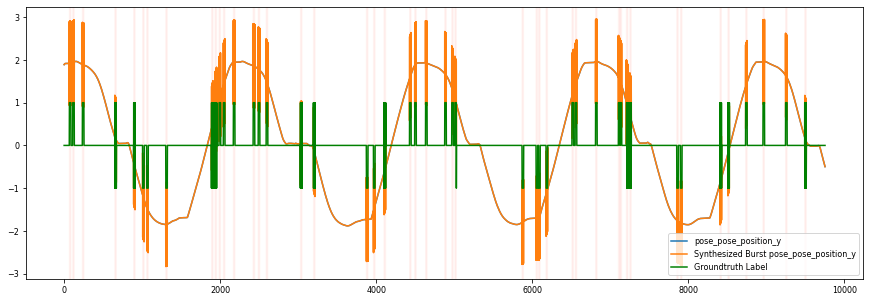

In [116]:
x = [i for i in range(len(origin_input_test_set))]
for i,feat in enumerate(cfg['feature_in']):
    plt.figure(figsize=(15,5))
    plt.plot(x, origin_input_test_set.values[:,i], label=feat)
    plt.plot(x, synth_burst_input_test.values[:,i], label='Synthesized Burst {}'.format(feat))
    for column in anomalous_indices_burst:
        plt.axvline(x=column, color=sns.xkcd_rgb["peach"],alpha=.01)
    plt.plot(x, anomalous_labels_burst*np.sign(synth_burst_input_test.values[:,i]),
             color='g', label='Groundtruth Label')


plt.legend()
plt.show()

# Part 2: Other csv files


In [16]:
temp_cmd_vel = pd.read_csv('../dataset/turtlebot3/normal/cmd_vel.csv')

<AxesSubplot:>

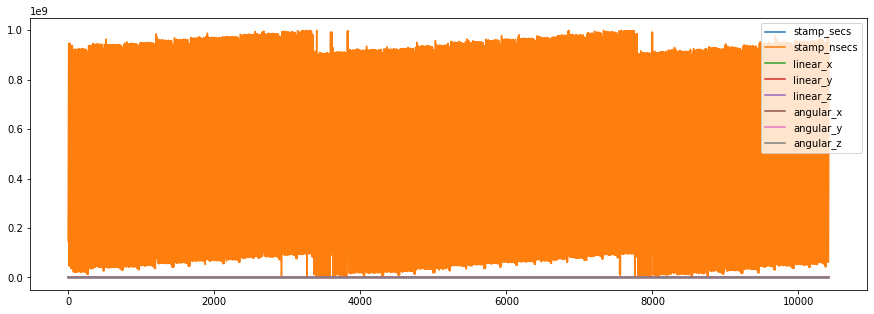

In [19]:
temp_cmd_vel.plot.line( figsize=(15,5))

<AxesSubplot:title={'center':'cmd_vel linear'}>

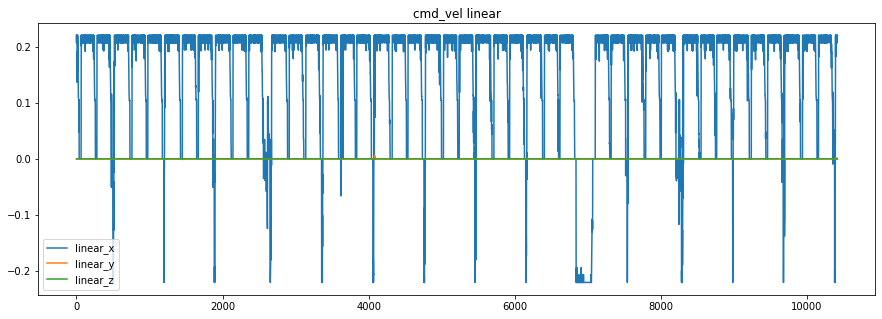

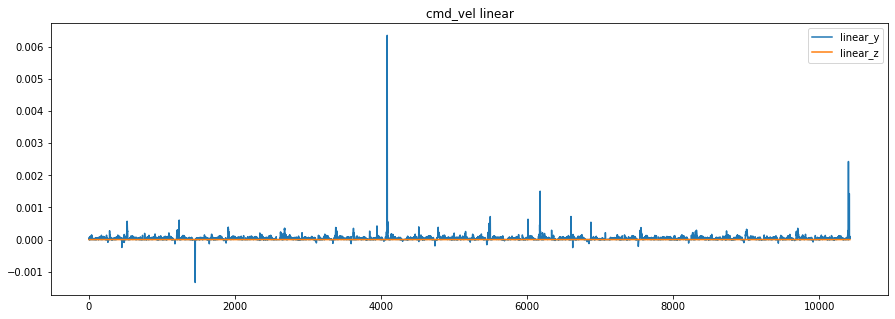

In [21]:
temp_cmd_vel.plot.line(y=['linear_x', 'linear_y', 'linear_z'], title='cmd_vel linear', figsize=(15,5))
temp_cmd_vel.plot.line(y=['linear_y', 'linear_z'], title='cmd_vel linear', figsize=(15,5))

<AxesSubplot:title={'center':'cmd_vel angular'}>

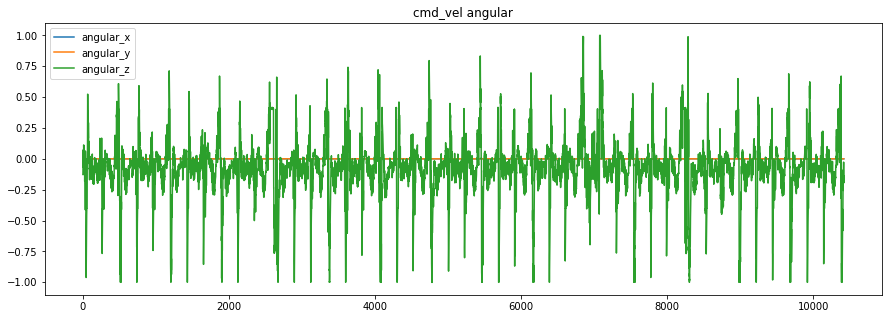

In [20]:
temp_cmd_vel.plot.line(y=['angular_x', 'angular_y', 'angular_z'], title='cmd_vel angular', figsize=(15,5))

<AxesSubplot:title={'center':'cmd_vel angular'}>

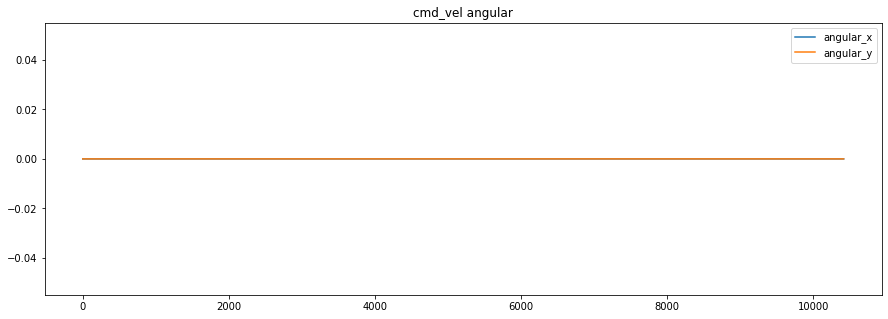

In [22]:
temp_cmd_vel.plot.line(y=['angular_x', 'angular_y'], title='cmd_vel angular', figsize=(15,5))

In [23]:
temp_imu = pd.read_csv('../dataset/turtlebot3/normal/imu.csv')

In [24]:
temp_imu.head()

header_seq  h_stamp_secs  h_stamp_nsecs  orientation_x  orientation_y  \
0        4702         13357       51000000      -0.003847       0.000257   
1        4703         13357       56000000      -0.003847       0.000258   
2        4704         13357       61000000      -0.003846       0.000257   
3        4705         13357       66000000      -0.003847       0.000256   
4        4706         13357       71000000      -0.003847       0.000258   

   orientation_z  angular_x  angular_y  angular_z  linear_accel_x  \
0       0.997611   0.000478  -0.000151  -0.085955        0.006456   
1       0.997596   0.000495  -0.000164  -0.085857       -0.004989   
2       0.997582  -0.002417  -0.002698  -0.080353        0.086822   
3       0.997570   0.001385   0.001101  -0.055383        0.322304   
4       0.997564   0.000180  -0.001012  -0.026329        0.371627   

   linear_accel_y  linear_accel_z  
0        0.000818        0.000048  
1       -0.013452       -0.000028  
2       -0.044960       -0.011685  
3       -0.104603        0.008199  
4       -0.119521        0.020066

<AxesSubplot:title={'center':'orientation'}>

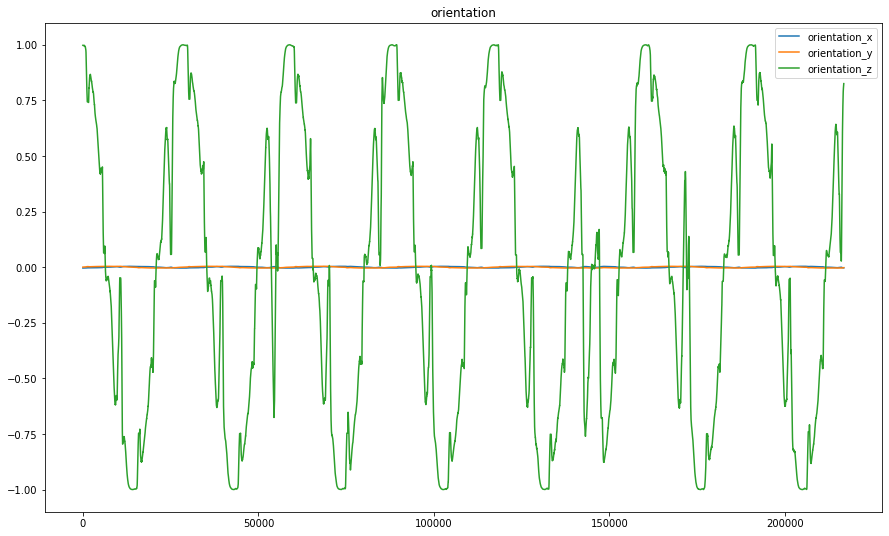

In [25]:
temp_imu.plot.line(y=['orientation_x', 'orientation_y', 'orientation_z'], title='orientation', figsize=(15,9))

<AxesSubplot:title={'center':'angular'}>

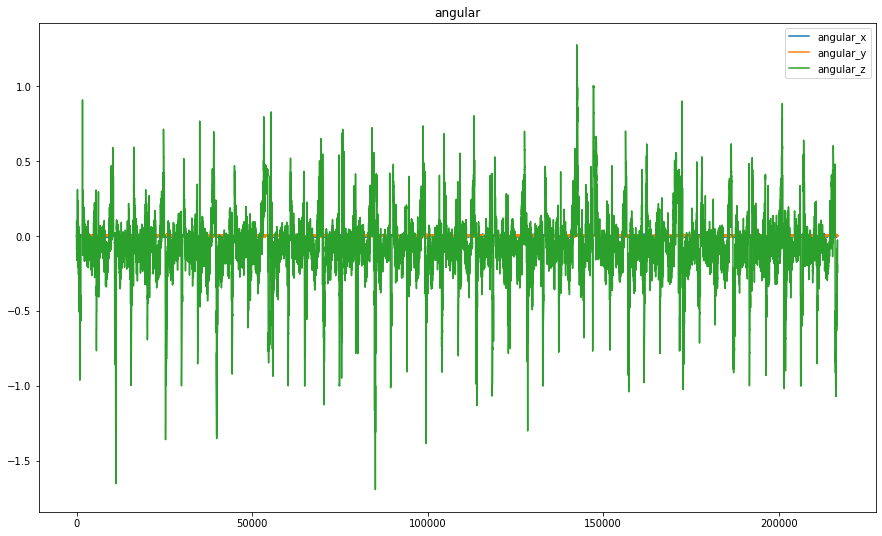

In [26]:
temp_imu.plot.line(y=['angular_x', 'angular_y', 'angular_z'], title='angular', figsize=(15,9))

<AxesSubplot:title={'center':'angular'}>

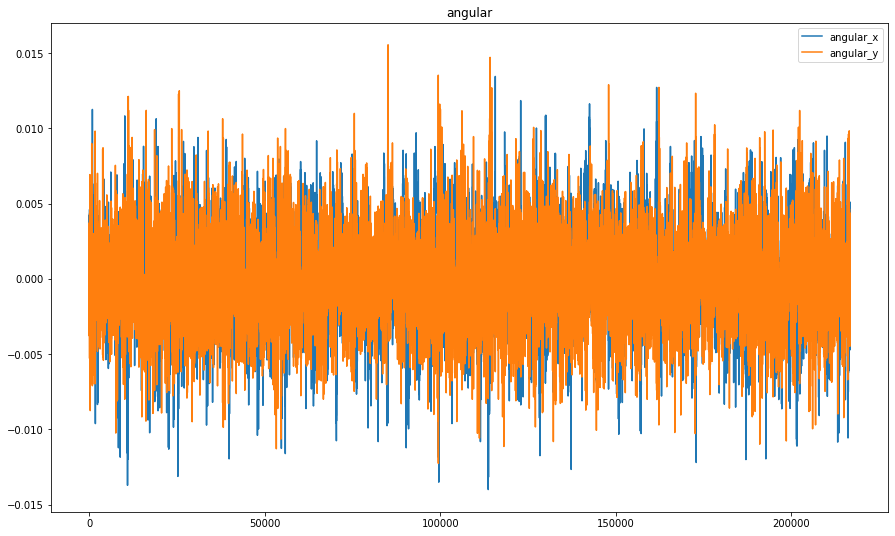

In [27]:
temp_imu.plot.line(y=['angular_x', 'angular_y'], title='angular', figsize=(15,9))

<AxesSubplot:title={'center':'linear_accel'}>

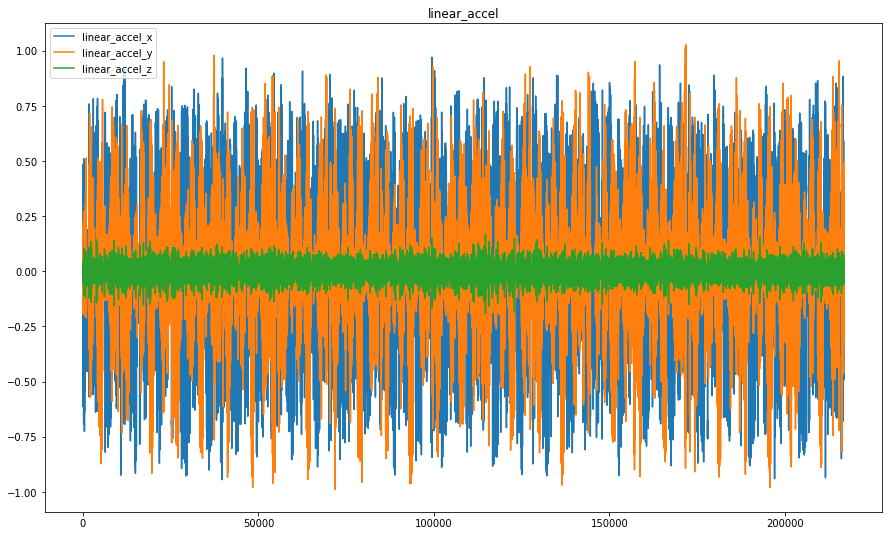

In [28]:
temp_imu.plot.line(y=['linear_accel_x', 'linear_accel_y', 'linear_accel_z'], title='linear_accel', figsize=(15,9))

# Part 3: Attack Datasets

In [25]:
attack_dir = '../dataset/turtlebot3/attack_pentagon'
attack_odom = pd.read_csv('{}/odometry.csv'.format(attack_dir))


In [55]:
print(attack_odom.shape)
attack_odom.head(50)

(14425, 16)


header_seq  h_stamp_secs  h_stamp_nsecs  pose_pose_position_x  \
0         1779            59      522000000             -1.583143   
1         1780            59      555000000             -1.585969   
2         1781            59      589000000             -1.589038   
3         1782            59      620000000             -1.592023   
4         1783            59      655000000             -1.594984   
5         1784            59      689000000             -1.597988   
6         1785            59      722000000             -1.600885   
7         1786            59      755000000             -1.603763   
8         1787            59      789000000             -1.606709   
9         1788            59      822000000             -1.609548   
10        1789            59      855000000             -1.612360   
11        1790            59      889000000             -1.615220   
12        1791            59      922000000             -1.617973   
13        1792            59      955000000             -1.620693   
14        1793            59      989000000             -1.623461   
15        1794            60       22000000             -1.626113   
16        1795            60       55000000             -1.628729   
17        1796            60       89000000             -1.631386   
18        1797            60      122000000             -1.633921   
19        1798            60      155000000             -1.636420   
20        1799            60      189000000             -1.638969   
21        1800            60      222000000             -1.641289   
22        1801            60      255000000             -1.643540   
23        1802            60      289000000             -1.645841   
24        1803            60      322000000             -1.648092   
25        1804            60      355000000             -1.650394   
26        1805            60      389000000             -1.652737   
27        1806            60      419000000             -1.654976   
28        1807            60      455000000             -1.657184   
29        1808            60      489000000             -1.659425   
30        1809            60      522000000             -1.661567   
31        1810            60      555000000             -1.663690   
32        1811            60      589000000             -1.665853   
33        1812            60      622000000             -1.667942   
34        1813            60      655000000             -1.670022   
35        1814            60      689000000             -1.672149   
36        1815            60      722000000             -1.674069   
37        1816            60      755000000             -1.675730   
38        1817            60      789000000             -1.677187   
39        1818            60      822000000             -1.678372   
40        1819            60      855000000             -1.679345   
41        1820            60      889000000             -1.680126   
42        1821            60      922000000             -1.680718   
43        1822            60      955000000             -1.681239   
44        1823            60      989000000             -1.681691   
45        1824            61       22000000             -1.682091   
46        1825            61       55000000             -1.682418   
47        1826            61       89000000             -1.682728   
48        1827            61      122000000             -1.683081   
49        1828            61      155000000             -1.683443   

    pose_pose_position_y  pose_pose_position_z  pose_pose_orientation_x  \
0              -1.350467             -0.001002                 0.003253   
1              -1.344297             -0.001001                 0.003243   
2              -1.337521             -0.001002                 0.003244   
3              -1.330880             -0.001002                 0.003239   
4              -1.324211             -0.001002                 0.003237   
5              -1.317356          

In [63]:
attack_odom.tail(10)

header_seq  h_stamp_secs  h_stamp_nsecs  pose_pose_position_x  \
14415       16194           540       22000000             -0.533814   
14416       16195           540       55000000             -0.526526   
14417       16196           540       89000000             -0.519015   
14418       16197           540      122000000             -0.511726   
14419       16198           540      155000000             -0.504439   
14420       16199           540      189000000             -0.496939   
14421       16200           540      222000000             -0.489685   
14422       16201           540      255000000             -0.482413   
14423       16202           540      289000000             -0.474915   
14424       16203           540      322000000             -0.468045   

       pose_pose_position_y  pose_pose_position_z  pose_pose_orientation_x  \
14415              1.898024             -0.001002                -0.000048   
14416              1.898171             -0.001002                -0.000043   
14417              1.898297             -0.001002                -0.000037   
14418              1.898396             -0.001002                -0.000032   
14419              1.898473             -0.001002                -0.000027   
14420              1.898529             -0.001002                -0.000022   
14421              1.898565             -0.001001                -0.000012   
14422              1.898586             -0.001002                -0.000011   
14423              1.898591             -0.001002                -0.000006   
14424              1.898581             -0.001002                -0.000007   

       pose_pose_orientation_y  pose_pose_orientation_z  \
14415                -0.000048                 0.010854   
14416                -0.000043                 0.009206   
14417                -0.000037                 0.007506   
14418                -0.000032                 0.005975   
14419                -0.000027                 0.004454   
14420                -0.000022                 0.002937   
14421                -0.000012                 0.001960   
14422                -0.000011                 0.000884   
14423                -0.000006                -0.000253   
14424                -0.000007                -0.001295   

       pose_pose_orientation_w  twist_twist_linear_x  twist_twist_linear_y  \
14415                 0.999934              0.220901              0.000038   
14416                 0.999950              0.220921              0.000038   
14417                 0.999964              0.220956              0.000038   
14418                 0.999975              0.220878              0.000031   
14419                 0.999983              0.220817              0.000027   
14420                 0.999988              0.220116              0.000051   
14421                 0.999991              0.219733              0.000027   
14422                 0.999992              0.220523              0.000021   
14423                 0.999993              0.220560              0.000021   
14424                 0.999992              0.196453              0.000010   

       twist_twist_linear_z  twist_twist_angular_x  twist_twist_angular_y  \
14415                   0.0                    0.0                    0.0   
14416                   0.0                    0.0                    0.0   
14417                   0.0                    0.0                    0.0   
14418                   0.0                    0.0                    0.0   
14419                   0.0                    0.0                    0.0   
14420                   0.0                    0.0                    0.0   
14421                   0.0                    0.0                    0.0   
14422                   0.0                    0.0                    0.0   
14423                   0.0                    0.0                    0.0   
14424                   0.0                    0.0                    0.0   

In [68]:
hack_cmd = pd.read_csv('{}/hack_cmd.csv'.format(attack_dir))
print(hack_cmd.shape)
hack_cmd.head()

(6504, 8)


stamp_secs  stamp_nsecs  linear_x  linear_y  linear_z  angular_x  \
0          59    593000000       0.0       0.0       0.0        0.0   
1          59    688000000       0.0       0.0       0.0        0.0   
2          59    783000000       0.0       0.0       0.0        0.0   
3          59    881000000       0.0       0.0       0.0        0.0   
4          59    971000000       0.0       0.0       0.0        0.0   

   angular_y  angular_z  
0        0.0        0.0  
1        0.0        0.0  
2        0.0        0.0  
3        0.0        0.0  
4        0.0        0.0

In [69]:
hack_cmd.tail()

stamp_secs  stamp_nsecs  linear_x  linear_y  linear_z  angular_x  \
6499         539    956000000       0.0       0.0       0.0        0.0   
6500         540     52000000       0.0       0.0       0.0        0.0   
6501         540    150000000       0.0       0.0       0.0        0.0   
6502         540    247000000       0.0       0.0       0.0        0.0   
6503         540    342000000       0.0       0.0       0.0        0.0   

      angular_y  angular_z  
6499        0.0        0.0  
6500        0.0        0.0  
6501        0.0        0.0  
6502        0.0        0.0  
6503        0.0        0.0

In [58]:
hack_cmd['stamp_secs'].value_counts()

362    35
489    35
513    34
241    34
350    34
       ..
173    10
79     10
537    10
59      5
540     4
Name: stamp_secs, Length: 482, dtype: int64

In [67]:
attack_odom['h_stamp_secs'].value_counts()

535    30
527    30
314    30
322    30
330    30
       ..
253    30
261    30
501    30
59     15
540    10
Name: h_stamp_secs, Length: 482, dtype: int64

* **How to anotate anomalous label?**
We observe that `attack_odom` get data with frequency of 30 packets/s, while `hack_cmd` frequency is vary because of user input frequency. But all of them are aligned by the absolute value of `stamp_secs`. Therefore, we label the `attack_odom` based on `hack_cmd` align with `stamp_secs`. Specifically, we examine if a second of `hack_cmd` that has more than half of commands are anomalous, then we assign this second as anomalous. Then mapping to the attack_odom data with the same `stamp_secs` as anomalous data.

Define an attack label as one of the value of `hack_cmd` is not equal to zero.

If we need strictly synchronized label with `stamp_secs`, we need to synchronize `attack_odom.h_stamp_sec` and `hack_cmd.stamp_secs`.
We observe that both dataframes have the same number of `stamp_secs`.

In [71]:
def anotation(row):
    if (row['linear_x']==0 and row['linear_y']==0 and row['linear_z']==0
        and row['angular_x']==0 and row['angular_y']==0 and row['angular_z']==0):
        return 0
    else:
        return 1
hack_cmd['label'] = hack_cmd.apply(anotation, axis=1)
hack_cmd.head()                          

stamp_secs  stamp_nsecs  linear_x  linear_y  linear_z  angular_x  \
0          59    593000000       0.0       0.0       0.0        0.0   
1          59    688000000       0.0       0.0       0.0        0.0   
2          59    783000000       0.0       0.0       0.0        0.0   
3          59    881000000       0.0       0.0       0.0        0.0   
4          59    971000000       0.0       0.0       0.0        0.0   

   angular_y  angular_z  label  
0        0.0        0.0      0  
1        0.0        0.0      0  
2        0.0        0.0      0  
3        0.0        0.0      0  
4        0.0        0.0      0

In [73]:
# create a second-based labels:
min_stamp = hack_cmd['stamp_secs'].min()
max_stamp = hack_cmd['stamp_secs'].max()
print(min_stamp, max_stamp)

59 540


In [100]:
labels = {}
for i in range(min_stamp, max_stamp + 1):
    temp = hack_cmd.loc[hack_cmd['stamp_secs']==i]['label'].values
    labels[i] = 1 if sum(temp)/len(temp) >= 0.5 else 0
print(labels)

{59: 0, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 138: 0, 139: 0, 140: 0, 141: 0, 142: 0, 143: 0, 144: 0, 145: 0, 146: 0, 147: 0, 148: 0, 149: 0, 150: 0, 151: 0, 152: 0, 153: 0, 154: 0, 155: 0, 156: 0, 157: 0, 158: 1, 159: 1, 160: 1, 161: 1, 162: 1, 163: 1, 164: 1, 165: 1, 166: 1, 167: 1, 168: 1, 169: 1, 170: 1, 171: 1, 172: 1, 173: 1, 174: 1, 175: 1, 176: 1, 177: 1, 178: 1, 179: 1, 180: 1, 181: 1, 182: 1, 183: 1, 184: 0, 185: 0, 186: 0, 187: 0, 188: 0, 

In [98]:
def map_label(row, labels):
    return labels[row['h_stamp_secs']]
attack_odom['label'] = attack_odom.apply(map_label, args=(labels,), axis=1)

In [102]:
print(attack_odom['label'])

0        0
1        0
2        0
3        0
4        0
        ..
14420    0
14421    0
14422    0
14423    0
14424    0
Name: label, Length: 14425, dtype: int64


In [99]:
attack_odom.head(10)

header_seq  h_stamp_secs  h_stamp_nsecs  pose_pose_position_x  \
0        1779            59      522000000             -1.583143   
1        1780            59      555000000             -1.585969   
2        1781            59      589000000             -1.589038   
3        1782            59      620000000             -1.592023   
4        1783            59      655000000             -1.594984   
5        1784            59      689000000             -1.597988   
6        1785            59      722000000             -1.600885   
7        1786            59      755000000             -1.603763   
8        1787            59      789000000             -1.606709   
9        1788            59      822000000             -1.609548   

   pose_pose_position_y  pose_pose_position_z  pose_pose_orientation_x  \
0             -1.350467             -0.001002                 0.003253   
1             -1.344297             -0.001001                 0.003243   
2             -1.337521             -0.001002                 0.003244   
3             -1.330880             -0.001002                 0.003239   
4             -1.324211             -0.001002                 0.003237   
5             -1.317356             -0.001001                 0.003223   
6             -1.310675             -0.001002                 0.003226   
7             -1.303983             -0.001002                 0.003222   
8             -1.297079             -0.001002                 0.003218   
9             -1.290358             -0.001002                 0.003214   

   pose_pose_orientation_y  pose_pose_orientation_z  pose_pose_orientation_w  \
0                 0.003253                -0.842311                -0.538978   
1                 0.003243                -0.840737                -0.541430   
2                 0.003244                -0.840131                -0.542370   
3                 0.003239                -0.838948                -0.544197   
4                 0.003237                -0.837643                -0.546204   
5                 0.003223                -0.836401                -0.548104   
6                 0.003226                -0.835576                -0.549362   
7                 0.003222                -0.834769                -0.550586   
8                 0.003218                -0.833935                -0.551850   
9                 0.003214                -0.832809                -0.553547   

   twist_twist_linear_x  twist_twist_linear_y  twist_twist_linear_z  \
0              0.195646              0.000063                   0.0   
1              0.213628              0.000050                   0.0   
2              0.220441              0.000013                   0.0   
3              0.221371              0.000071                   0.0   
4              0.220872              0.000075                   0.0   
5              0.220155              0.000045                   0.0   
6              0.220781              0.000028                   0.0   
7              0.220771              0.000030                   0.0   
8              0.220787              0.000032                   0.0   
9              0.221091              0.000044                   0.0   

   twist_twist_angular_x  twist_twist_angular_y  twist_twist_angular_z  label  
0                    0.0                    0.0              -0.184481      0  
1                    0.0                    0.0              -0.135770      0  
2                    0.0                    0.0              -0.042349      0  
3                    0.0                    0.0              -0.147835      0  
4                    0.0                    0.0              -0.142038      0  
5                    0.0                    0.0              -0.133856      0  
6                    0.0                    0.0              -0.089004      0  
7                    0.0                    0.0              -0.088684      0  
8                    0.0                    0.0         

## Plot attack data

<AxesSubplot:title={'center':'Feature input (Pose position)'}>

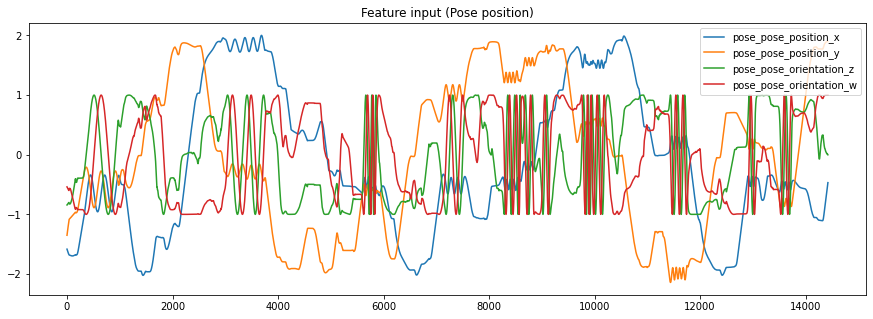

In [39]:
attack_odom.plot.line(y=cfg['feature_in'][:4], title='Feature input (Pose position)', figsize=(15,5))

<AxesSubplot:title={'center':'Feature input (Twist cmd_vel)'}>

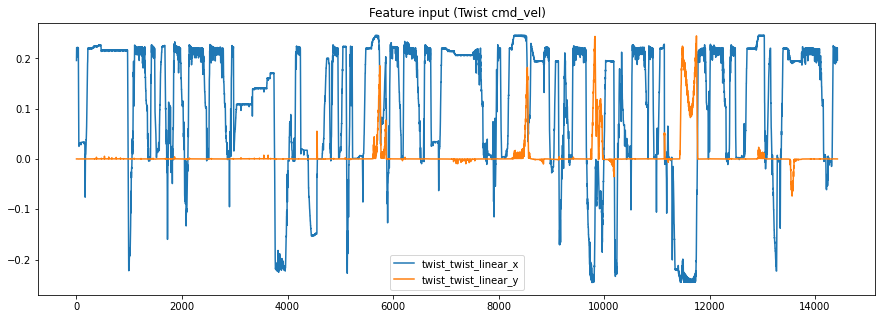

In [24]:
attack_odom.plot.line(y=cfg['feature_in'][4:6], title='Feature input (Twist cmd_vel)', figsize=(15,5))

<AxesSubplot:title={'center':'Feature input (Twist cmd_vel)'}>

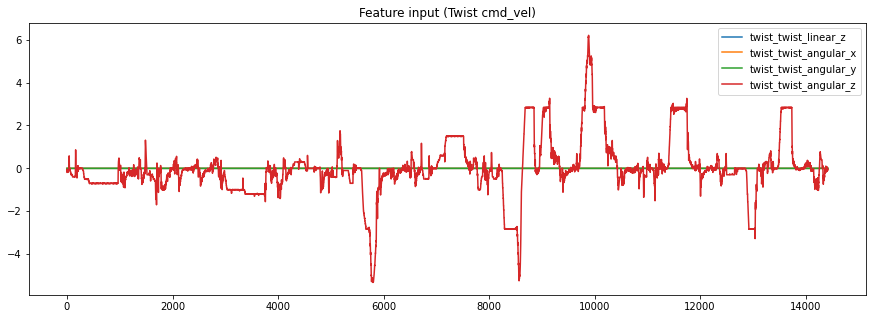

In [38]:
attack_odom.plot.line(y=cfg['feature_in'][6:10], title='Feature input (Twist cmd_vel)', figsize=(15,5))